# Model Comparison: Cross-Domain Performance Analysis

This document outlines a series of experiments designed to evaluate different model training strategies for **fiber orientation prediction**. The goal is to compare how well each strategy generalizes to an **unseen biological test set**.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pickle

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.svr_hog.data_processing import load_dataset
from fiber_predictor.svr_hog.models import FiberPredictor
from fiber_predictor.utils.split_utils import split_dataset_temp

IMAGE_DIR = '../../images'
MODEL_DIR = '../../models'

## 0. Configuration & Data Splitting

Before proceeding with model training, we define a configuration dictionary for **HOG parameters** and **angle binning**, and then **physically split** the original biological dataset into separate training and testing directories. This ensures:

- **Parameter Consistency**: The `config` dictionary centralizes key settings like the `grid_quotient`, `orientations`, and `angle_bins` used for HOG feature extraction and balancing.
- **Isolated Testing**: By using `split_dataset_temp`, we move 20% of the biological images (and their labels) into a dedicated test folder. These images remain untouched throughout the training and validation phases, guaranteeing a clean, unseen evaluation set for final performance metrics.

The resulting paths for **bio_train_folder** and **bio_test_folder** (along with their respective CSV files) will be referenced in subsequent steps for data loading and preprocessing.


In [ ]:
# Model/Inference Parameters
config = {
    'grid_quotient': np.arange(1, 4),
    'orientations': 10,
    'angle_bins': np.arange(0, 181, 20),
}

In [3]:
# Physically split the BIO dataset so we can reserve some for testing
bio_orig_folder = os.path.join(IMAGE_DIR, "bio")
bio_temp, (bio_train_folder, bio_train_csv), (bio_test_folder, bio_test_csv) = split_dataset_temp(
    bio_orig_folder,
    labels_csv_name="labels.csv",
    test_size=0.2,
    random_seed=42
)


Dataset split into temp folder: /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmpbr1kecp4
 Train folder: /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmpbr1kecp4/train  (538 images)
 Test folder : /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmpbr1kecp4/test   (135 images)



In [4]:
# Dataset paths
bio_file_dir = bio_train_folder
bio_csv_dir = bio_train_csv

diff_file_dir = os.path.join(IMAGE_DIR, "diffusion/")
diff_csv_dir = os.path.join(IMAGE_DIR, "diffusion/labels.csv")


## 1. Data Loading and Initial Processing

This section describes how we:

1. **Physically Split the Biological Dataset**:  
   We use our custom `split_dataset_temp` utility to move 20% of the biological images into a separate test folder (`bio_test_folder`) with its own CSV (`bio_test_csv`). This ensures the final test set remains entirely unseen during training or validation.

2. **Identify and Load Images**:  
   We then load the **training portion** (80%) of the biological dataset from `bio_train_folder` and `bio_train_csv`, as well as the diffusion dataset from its respective folder. Each dataset includes a CSV file linking images to their corresponding orientation labels.

3. **Extract HOG Features**:  
   Each image is converted into a **Histogram of Oriented Gradients (HOG)** feature vector, with parameters defined in our `config` dictionary (e.g., `grid_quotient` and `orientations`).

4. **Optional Data Augmentation**:  
   To boost data diversity, we can apply transformations (rotations, flips) to images prior to extracting HOG features.

5. **Balancing Strategy**:  
   If certain orientation angles are under-represented, we can upsample them (using bins like 0–20°, 20–40°, etc.).

Finally, we load the **held-out test set** from `bio_test_folder` and `bio_test_csv`. These samples are completely excluded from training and validation, guaranteeing a true assessment of generalization.


In [5]:
# Load all training datasets
print("Loading training datasets...")

bio_raw = load_dataset(bio_file_dir, bio_csv_dir, config)
bio_balanced = load_dataset(bio_file_dir, bio_csv_dir, config, balance=True)
bio_aug = load_dataset(bio_file_dir, bio_csv_dir, config, augment=True)
bio_aug_balanced = load_dataset(bio_file_dir, bio_csv_dir, config, augment=True, balance=True)

# Diffusion datasets
diff_raw = load_dataset(diff_file_dir, diff_csv_dir, config)
diff_balanced = load_dataset(diff_file_dir, diff_csv_dir, config, balance=True)
diff_aug = load_dataset(diff_file_dir, diff_csv_dir, config, augment=True)
diff_aug_balanced = load_dataset(diff_file_dir, diff_csv_dir, config, augment=True, balance=True)

# Combined datasets
combined_raw = {
    'features': np.vstack([bio_raw['features'], diff_raw['features']]),
    'labels': np.concatenate([bio_raw['labels'], diff_raw['labels']]),
    'n_samples': bio_raw['n_samples'] + diff_raw['n_samples']
}
combined_balanced = {
    'features': np.vstack([bio_balanced['features'], diff_balanced['features']]),
    'labels': np.concatenate([bio_balanced['labels'], diff_balanced['labels']]),
    'n_samples': bio_balanced['n_samples'] + diff_balanced['n_samples']
}
combined_aug = {
    'features': np.vstack([bio_aug['features'], diff_raw['features']]),
    'labels': np.concatenate([bio_aug['labels'], diff_raw['labels']]),
    'n_samples': bio_aug['n_samples'] + diff_raw['n_samples']
}
combined_aug_balanced = {
    'features': np.vstack([bio_aug_balanced['features'], diff_aug_balanced['features']]),
    'labels': np.concatenate([bio_aug_balanced['labels'], diff_aug_balanced['labels']]),
    'n_samples': bio_aug_balanced['n_samples'] + diff_aug_balanced['n_samples']
}

# Load the test dataset
print("Loading test dataset...")
bio_test = load_dataset(bio_test_folder, bio_test_csv, config)

Loading training datasets...
Loading test dataset...


In [6]:

print("\nDataset Sizes:")
print(f"Bio Test Set: {bio_test['n_samples']} samples")

print(f"\nBio Training Sets:")
print(f"Raw: {bio_raw['n_samples']} samples")
print(f"Balanced: {bio_balanced['n_samples']} samples")
print(f"Augmented: {bio_aug['n_samples']} samples")
print(f"Augmented+Balanced: {bio_aug_balanced['n_samples']} samples")

print(f"\nDiffusion Training Sets:")
print(f"Raw: {diff_raw['n_samples']} samples")
print(f"Balanced: {diff_balanced['n_samples']} samples")
print(f"Augmented: {diff_aug['n_samples']} samples")
print(f"Augmented+Balanced: {diff_aug_balanced['n_samples']} samples")

print(f"\nCombined Training Sets:")
print(f"Raw: {combined_raw['n_samples']} samples")
print(f"Balanced: {combined_balanced['n_samples']} samples")
print(f"Augmented: {combined_aug['n_samples']} samples")
print(f"Augmented+Balanced: {diff_aug_balanced['n_samples']} samples")

# Tracking DataFrame
tracking_data = []


Dataset Sizes:
Bio Test Set: 135 samples

Bio Training Sets:
Raw: 538 samples
Balanced: 90 samples
Augmented: 3766 samples
Augmented+Balanced: 774 samples

Diffusion Training Sets:
Raw: 609 samples
Balanced: 306 samples
Augmented: 4263 samples
Augmented+Balanced: 3141 samples

Combined Training Sets:
Raw: 1147 samples
Balanced: 396 samples
Augmented: 4375 samples
Augmented+Balanced: 3141 samples


## 2. Model Training and Evaluation Function

Here, we outline the approach used to train and evaluate each model:

1. **Model Architecture**:  
   - We utilize a custom predictor class (`FiberPredictor`) that includes:
     - **Scaling** (to normalize features),  
     - **PCA** (to reduce dimensionality while retaining 95% variance),  
     - **Support Vector Regressor (SVR)** (using an RBF kernel with specified `C` and `gamma` hyperparameters).

2. **Training Routine**:  
   - We split the feature-label pairs further into a training set (for fitting the model) and a validation set (for tuning and preliminary performance checks).

3. **Performance Metrics**:  
   - We measure **Mean Absolute Error (MAE)** as our main metric, reporting how many degrees off the predicted orientation is from the ground truth on average.  
   - Additional metrics like the R² score can provide extra insight but are secondary here.

4. **Validation and Test Evaluations**:  
   - Post-training, we evaluate on the validation set to detect any potential overfitting.  
   - Finally, we use the model to predict angles on the **unseen biological test set** to gauge generalization performance.

In [7]:
def train_evaluate_model(X_train, y_train, test_dataset, model_name=None):
    # Split training data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Train model
    model = FiberPredictor(
        scaler_type="Standard",
        pca_params={"n_components": 0.95},
        regressor_type="SVR",
        regressor_params={"kernel": "rbf", "C": 100, "gamma": 0.01}
    )
    model.fit(X_train_split, y_train_split)
    
    # Evaluate on training set
    train_pred = model.predict(X_train_split)
    train_mae = mean_absolute_error(y_train_split, train_pred)
    
    # Evaluate on validation set
    val_pred = model.predict(X_val_split)
    val_mae = mean_absolute_error(y_val_split, val_pred)
    
    # Evaluate on test set
    test_features = test_dataset['features']
    test_labels = test_dataset['labels']
    
    test_pred = model.predict(test_features)
    test_mae = mean_absolute_error(test_labels, test_pred)
    
    print(f"Train Set Performance:")
    print(f"MAE: {train_mae:.2f}°")
    
    print(f"Validation Set Performance:")
    print(f"MAE: {val_mae:.2f}°")
    
    print(f"Test Set Performance:")
    print(f"MAE: {test_mae:.2f}°")
    
    # Track results
    result = {
        'model_name': model_name,
        'training_data': model_name.split('_')[0],
        'approach': '_'.join(model_name.split('_')[1:]),
        'n_train': len(X_train_split),
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
    }
    
    tracking_data.append(result)
    
    # Save model if name provided
    if model_name:
        with open(os.path.join(MODEL_DIR, f'svr_hog/{model_name}.pkl'), 'wb') as f:
            pickle.dump(model, f)
    
    return model, test_pred


## 3. Training and Evaluation Scenarios

We systematically train and evaluate models based on three sources (Bio, Diff, Combined), each with four approaches:

1. **Raw** – No augmentation or balancing  
2. **Balanced** – Upsampled for angle uniformity  
3. **Augmented** – Augmented via random transformations  
4. **Augmented + Balanced** – Both augmentation and balancing applied

**Bio-Trained Models**  
- Raw, Balanced, Augmented, Augmented+Balanced

**Diffusion-Trained Models**  
- Raw, Balanced, Augmented, Augmented+Balanced

**Combined Models (Bio + Diff)**  
- Raw, Balanced, Augmented, Augmented+Balanced

After training on each configuration, we evaluate on the **unseen biological test set** created via `split_dataset_temp`. We measure **Mean Absolute Error (MAE)** on the training, validation, and final test splits to determine which approach best generalizes.

In [8]:
# Define dataset configurations to train
datasets = {
    'bio': {
        'raw': bio_raw,
        'balanced': bio_balanced,
        'augmented': bio_aug,
        'augmented_balanced': bio_aug_balanced,
    },
    'diff': {
        'raw': diff_raw,
        'balanced': diff_balanced,
        'augmented': diff_aug_balanced,
        'augmented_balanced': diff_aug_balanced,
    },
    'combined': {
        'raw': combined_raw,
        'balanced': combined_balanced,
        'augmented': combined_aug,
        'augmented_balanced': combined_aug_balanced,
    }
}

# Dictionary to store trained models and predictions
models = {}
predictions = {}

# Train all models using a loop
for source, approaches in datasets.items():
    print(f"{'=' * 30}")
    print(f"Training {source.upper()}-based models:")
    print(f"{'=' * 30}")
    
    for approach, data in approaches.items():
        model_name = f"{source}_{approach}"
        print(f"\nTraining {approach} {source} model...")
        
        model, pred = train_evaluate_model(
            data['features'],
            data['labels'],
            bio_test,
            model_name=model_name
        )
        
        # Store model and predictions
        models[model_name] = model
        predictions[model_name] = pred
        
        print(f"Model '{model_name}' trained and evaluated.\n")


Training BIO-based models:

Training raw bio model...
Train Set Performance:
MAE: 7.71°
Validation Set Performance:
MAE: 10.49°
Test Set Performance:
MAE: 15.41°
Model 'bio_raw' trained and evaluated.


Training balanced bio model...
Train Set Performance:
MAE: 4.39°
Validation Set Performance:
MAE: 10.16°
Test Set Performance:
MAE: 17.60°
Model 'bio_balanced' trained and evaluated.


Training augmented bio model...
Train Set Performance:
MAE: 8.34°
Validation Set Performance:
MAE: 12.13°
Test Set Performance:
MAE: 15.38°
Model 'bio_augmented' trained and evaluated.


Training augmented_balanced bio model...
Train Set Performance:
MAE: 8.46°
Validation Set Performance:
MAE: 12.70°
Test Set Performance:
MAE: 17.15°
Model 'bio_augmented_balanced' trained and evaluated.

Training DIFF-based models:

Training raw diff model...
Train Set Performance:
MAE: 5.52°
Validation Set Performance:
MAE: 12.68°
Test Set Performance:
MAE: 19.01°
Model 'diff_raw' trained and evaluated.


Training balanc

## 4. Results Summary

Finally, all trained models are evaluated on the **biological test set**, and we record the following:

1. **Train MAE**: Error on the training subset (used to fit the model).  
2. **Validation MAE**: Error on the internal validation subset (for hyperparameter checks and overfitting detection).  
3. **Test MAE**: Error on the **unseen biological test set** (the key metric of generalization).

A summary table ranks the models by **Test MAE**, enabling us to pinpoint which training approach yields the best performance on biological data. A bar chart can also illustrate how each data source and preprocessing choice performs relative to the others.

Model Performance Summary (sorted by test MAE):


,model_name,training_data,approach,n_train,train_mae,val_mae,test_mae
2,bio_augmented,bio,augmented,3012,8.339145,12.127110,15.382494
0,bio_raw,bio,raw,430,7.709298,10.485409,15.407364
10,combined_augmented,combined,augmented,3500,8.404454,12.536568,15.444513
8,combined_raw,combined,raw,917,7.349943,12.135151,15.614225
3,bio_augmented_balanced,bio,augmented_balanced,619,8.458548,12.702053,17.146072
11,combined_augmented_balanced,combined,augmented_balanced,3132,7.556273,10.758322,17.165574
1,bio_balanced,bio,balanced,72,4.387639,10.161676,17.600621
6,diff_augmented,diff,augmented,2512,6.680752,9.791317,17.905155
7,diff_augmented_balanced,diff,augmented_balanced,2512,6.680752,9.791317,17.905155
4,diff_raw,diff,raw,487,5.523411,12.683950,19.007480


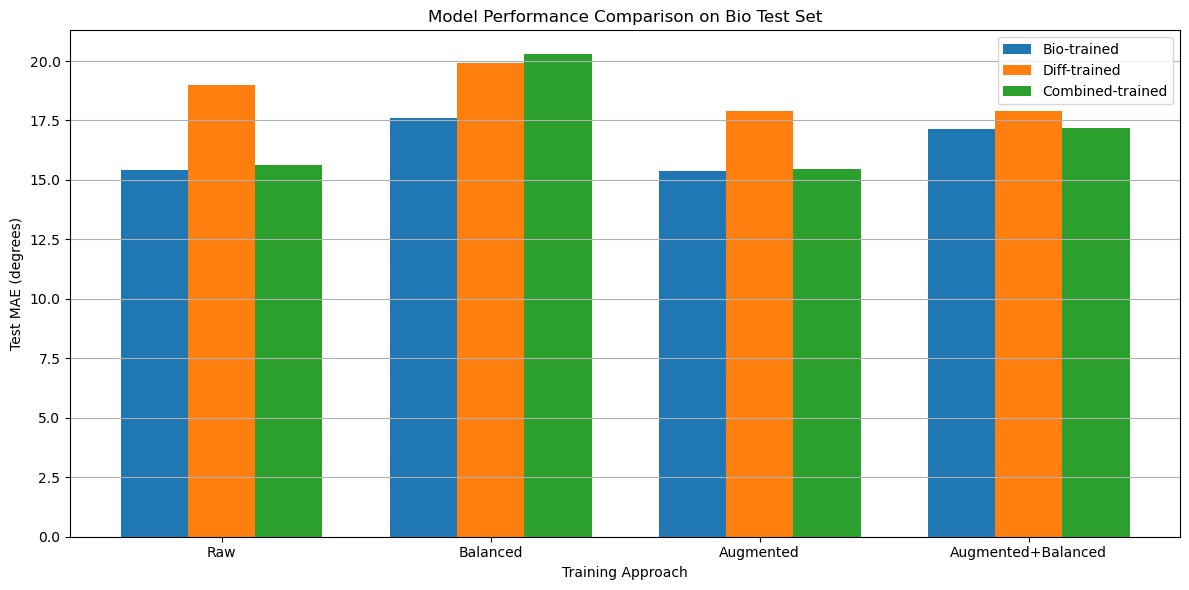

In [9]:
# Create summary DataFrame
summary_df = pd.DataFrame(tracking_data)

# Sort by test MAE to find best performing models
summary_df = summary_df.sort_values('test_mae')

# Display results
print("Model Performance Summary (sorted by test MAE):")
display(summary_df)

# Plot comparison by training data source and approach
plt.figure(figsize=(12, 6))

# Create positions for bars
x = np.arange(4)  # raw, balanced, augmented, augmented+balanced

# Plot bars for each training data source
for i, source in enumerate(['bio', 'diff', 'combined']):
    source_data = summary_df[summary_df['training_data'] == source]
    
    # Get MAE values aligned by approach
    raw = source_data[source_data['approach'] == 'raw']['test_mae'].values
    balanced = source_data[source_data['approach'] == 'balanced']['test_mae'].values
    augmented = source_data[source_data['approach'] == 'augmented']['test_mae'].values
    augmented_balanced = source_data[source_data['approach'] == 'augmented_balanced']['test_mae'].values
    
    # Plot available approaches
    values = []
    if len(raw) > 0: values.append(raw[0])
    if len(balanced) > 0: values.append(balanced[0])
    if len(augmented) > 0: values.append(augmented[0])
    if len(augmented_balanced) > 0: values.append(augmented_balanced[0])
    
    plt.bar(x[:len(values)] + i*0.25, values, 0.25, label=f'{source.capitalize()}-trained')

plt.xlabel('Training Approach')
plt.ylabel('Test MAE (degrees)')
plt.title('Model Performance Comparison on Bio Test Set')
plt.xticks(x + 0.25, ['Raw', 'Balanced', 'Augmented', 'Augmented+Balanced'])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Save summary to CSV
summary_df.to_csv(os.path.join(MODEL_DIR, 'svr_hog/model_comparison_summary.csv'), index=False)

### Conclusions

- **Bio-Only vs. Diffusion-Only**: Indicates the degree to which knowledge from one domain (diffusion) transfers to another (biology).  
- **Combined Training**: Explores whether merging both domains provides broader coverage and better generalization.  
- **Balancing & Augmentation**: Examines how carefully curating and expanding the dataset affects model robustness, especially when facing uneven or limited data.

Through these comparisons, we gain insights into the **optimal data source** and **preprocessing pipeline** for fiber orientation prediction, ultimately guiding future model deployment for unseen biological samples.